In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
from sklearn.model_selection import cross_val_score, KFold

In [2]:
from IPython.display import Image

In [3]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


## Project Details:

##### In this project we will build two Application :

* Recommendation Engine
* Book to movie predictor 

#### Recomendation Engine:
The recommendation engine will take a book title as input and will find similar books based on several different features like description, author, and genre, etc. 
#### Book to movie predictor:
This application will predict if a movie will be made into books or not.


##### Objective :
We will also use several different approaches for each of the applications and show a comparison.
But first, we have done some data processing to make the data in a format that is more suitable for the algorithms.

In [645]:
project_df=pd.read_csv('data/Poject_data.csv',error_bad_lines=False,index_col=0,encoding= 'unicode_escape')

In [646]:
project_df.columns

Index(['book_id', 'title', 'author', 'rating', 'num_pages',
       'number_of_ratings', 'text_reviews_count', 'year', 'publisher',
       'description', 'awards', 'genre', 'Movie', 'year_clean'],
      dtype='object')

In [647]:
project_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17234 entries, 0 to 17246
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   book_id             17234 non-null  int64  
 1   title               17234 non-null  object 
 2   author              17234 non-null  object 
 3   rating              17234 non-null  float64
 4   num_pages           17234 non-null  int64  
 5   number_of_ratings   17234 non-null  int64  
 6   text_reviews_count  17234 non-null  object 
 7   year                17234 non-null  object 
 8   publisher           17234 non-null  object 
 9   description         17234 non-null  object 
 10  awards              17234 non-null  object 
 11  genre               17234 non-null  object 
 12  Movie               17234 non-null  object 
 13  year_clean          17234 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 2.0+ MB


In [648]:
project_df.head(1)

,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,652,2095690,27591,9/16/2006,Scholastic Inc.,The war against Voldemort is not going well; e...,3,fantasy_paranormal_fiction,yes,2006


###### Feature Description:
* book_id:This is the GoodReads book id
* title: Title of the book
* author: The primary author of the book 
* rating: The Avegare rating of the book
* num_pages: The number of pages in the book
* number_of_ratings: The total number of ratings the book recieved in GoodReads
* text_reviews_count: The tital number of reviews the book recieved in GoodReads
* publisher: The publisher of the paper back version of the book
* description: A short description of what the book is about
* awards: The number of awards the book recieved
* genre: The genre of the book
* Movie: IF there is a move based on the book
* year: The year book was published in 

In [649]:
project_df['description'][6]

'At last in paperback in one complete volume, here are the five novels from Douglas Adams\'s Hitchhiker series. "The Hitchhiker\'s Guide to the Galaxy"Seconds before the Earth is demolished for a galactic freeway, Arthur Dent is saved by Ford Prefect, a researcher for the revised Guide. Together they stick out their thumbs to the stars and begin a wild journey through time and space."The Restaurant at the End of the Universe"Facing annihilation at the hands of warmongers is a curious time to crave tea. It could only happen to the cosmically displaced Arthur Dent and his comrades as they hurtle across the galaxy in a desperate search for a place to eat."Life, the Universe and Everything"The unhappy inhabitants of planet Krikkit are sick of looking at the night sky- so they plan to destroy it. The universe, that is. Now only five individuals can avert Armageddon: mild-mannered Arthur Dent and his stalwart crew."So Long, and Thanks for All the Fish"Back on Earth, Arthur Dent is ready to b

As it can be seen that the movie description is in a raw format, we have to do some formatting to it.
* It consists of both uppercase and lowercase character, as our first Recommender system will use turn text to vectors this might be a problem as the same words will be treated differently if one is in uppercase another in lower. 
* We also have to remove stopwords from the description.  Stopwords are the words in any language which does not add much meaning to a sentence for example words like 'a',' an','be', 'is', 'the' etc. They can safely be ignored without sacrificing the meaning of the sentence.
* We should also remove the punctuations as it doesn't have any effect on the meaning of the text. 

In [650]:
## Some fuction to clean the description text 
def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text


project_df['description'] = project_df.description.apply(func = make_lower_case)
project_df['description'] = project_df.description.apply(func = remove_stop_words)
project_df['description'] = project_df.description.apply(func=remove_punctuation)

In [651]:
project_df=project_df[project_df['description']!='Not_given']

In [652]:
project_df.shape

(17234, 14)

As we are using are using the description mainly , we are removing entries with no description . 

In [653]:
'last paperback one complete volume five novels Douglas Adams s hitchhiker series the hitchhiker s guide galaxy seconds earth demolished galactic freeway Arthur dent saved ford prefect researcher revised guide together stick thumbs stars begin wild journey time-space the restaurant end universe facing annihilation hands warmongers curious time crave tea could happen cosmically displaced Arthur dent comrades hurtle across galaxy desperate search place eat life universe everything the unhappy inhabitants planet cricket sick looking night sky plan destroy it universe is five individuals avert armageddon mild-mannered Arthur dent stalwart crew so long thanks fish back earth Arthur dent ready believe past eight years figment stressed-out imagination gift-wrapped fishbowl cryptic inscription conspires thrust back reality speak mostly harmless just Arthur dent makes terrible mistake starting enjoy life hell breaks loose save earth total obliteration save guide hostile alien takeover save daughter herself also includes short story young Zaphod plays safe'project_df['description'][6]

'last paperback one complete volume five novels douglas adams s hitchhiker series the hitchhiker s guide galaxy seconds earth demolished galactic freeway arthur dent saved ford prefect researcher revised guide together stick thumbs stars begin wild journey time space the restaurant end universe facing annihilation hands warmongers curious time crave tea could happen cosmically displaced arthur dent comrades hurtle across galaxy desperate search place eat life universe everything the unhappy inhabitants planet krikkit sick looking night sky plan destroy it universe is five individuals avert armageddon mild mannered arthur dent stalwart crew so long thanks fish back earth arthur dent ready believe past eight years figment stressed out imagination gift wrapped fishbowl cryptic inscription conspires thrust back reality speak mostly harmless just arthur dent makes terrible mistake starting enjoy life hell breaks loose save earth total obliteration save guide hostile alien takeover save daug

This is the result after formatiing the text .

##  Recommender System 1
The First recommender System is made by finding the cosine similarities only between the description of the books vectorized using the TF-IDF vectorizer.

TF-IDF(Term Frequency Inverse Document Frequency) vectorizer, is a very common algorithm to transform the text into a meaningful representation of numbers. 
Below is given the formula for vectorizer.
We are using the max features of 5000, which means each entry will be converted into (5000,1)vector,


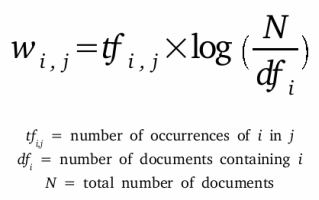

In [654]:
Image(filename='data/images/tf_idf.png') 

In [655]:
tf_idf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')


In [656]:
indices = pd.Series(project_df.index, index = project_df['title'])

In [657]:
tfidf_matrix_desc = tf_idf.fit_transform(project_df['description'])

In [658]:
similarity_mat_desc = cosine_similarity(tfidf_matrix_desc)

In [659]:
indices.shape

(17234,)

In [660]:
def tf_description(dataframe,similarity_mat,indices,book_name,no_books):
    idx = indices[book_name]
    sig = list(enumerate(similarity_mat[idx]))
    sig = sorted(sig, key=lambda x: x[1], reverse=True)
    sig = sig[1:no_books]
    book_indices = [i[0] for i in sig]
    book_df=dataframe[dataframe['title']==book_name]
    print("Book searched for: ")
    print(list(book_df['title'])[0])
    print('Author: ',list(book_df['author'])[0])
    print('Genre: ',list(book_df['genre'])[0])
    print("Similar books")
    return dataframe.iloc[book_indices]

The function takes in a few variables 
* data frame: the table from which it will take the corresponding Author, Genre of similar books
* similarity_mat: a matrix of 17235*17235 that contains the similarity of all the description 
* indices: the book name and the index of that book.
* book_name: the input book, whose similar books we will predict.
* no_books: The number of similar books we want to have

The function outputs a data frame containing similar books.

In [661]:
tf_description(project_df,similarity_mat_desc,indices,project_df['title'][3],6)

Book searched for: 
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
Author:  J.K. Rowling
Genre:  fantasy_paranormal_fiction
Similar books


,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,870,2153167,29221,9/1/2004,Scholastic Inc.,door end silent corridor itâ s haunting harry ...,9,fantasy_paranormal_fiction,yes,2004
12503,13563334,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.38,231,209,32,2012,"Scholastic, Inc",chamber secrets opened hogwarts school witchcr...,Not_given,fantasy_paranormal_fiction,no,2012
7429,43509,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,4.56,636,18754,906,7/8/2000,Bloomsbury,summer holidays dragging harry potter can t wa...,8,fantasy_paranormal_fiction,no,2000
10162,30167764,Harry Potter: Cinematic Guide,Not_given,3.79,64,158,15,2016,Scholastic Inc.,essential film companion harry potter that s p...,Not_given,children,no,2016
2969,15190,Looking for God in Harry Potter,John Granger,4.13,234,1347,94,2/17/2006,SaltRiver,millions children even christian children read...,0,history_biography,no,2006


In [662]:
tf_description(project_df,similarity_mat_desc,indices,project_df['title'][19],6)

Book searched for: 
The Lord of the Rings (The Lord of the Rings  #1-3)
Author:  J.R.R. Tolkien
Genre:  fantasy_paranormal_fiction
Similar books


,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean
10337,236159,"Dorothy and the Wizard of Oz (Oz, #4)",L. Frank Baum,3.78,140,177,10,2005,Dodo Press,large format easy reading wonderful wizard oz ...,Not_given,children,no,2005
12247,892555,"The Return of the King (The Lord of the Rings,...",J.R.R. Tolkien,4.51,436,341,19,2005,HarperCollins,classic hardback edition third volume lord rin...,Not_given,fantasy_paranormal_fiction,no,2005
3222,16546,Pictures by J.R.R. Tolkien,J.R.R. Tolkien,4.47,102,531,14,10/1/1992,Houghton Mifflin,sumptuous collection tolkien s art gain new un...,0,fantasy_paranormal_fiction,no,1992
9503,13528330,Starry River of the Sky,Grace Lin,4.08,288,249,75,2012,"Little, Brown Books for Young Readers",bestselling author grace lin comes companion n...,Not_given,children,no,2012
4345,23625,The History of Middle-Earth Index (The History...,J.R.R. Tolkien,4.25,484,51,3,8/5/2002,HarperCollins,although j r r tolkien well known hobbit lord ...,0,fantasy_paranormal_fiction,no,2002


In [663]:
tf_description(project_df,similarity_mat_desc,indices,project_df['title'][218],6)

Book searched for: 
Angels & Demons (Robert Langdon  #1)
Author:  Dan Brown
Genre:  fantasy_paranormal_fiction
Similar books


,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean
14261,3336510,"Angels & Demons (Robert Langdon, #1)",Dan Brown,3.86,572,692,48,2001,Pocket Books,takes guts write novel combines ancient secret...,Not_given,mystery_thriller_crime,no,2001
219,968,The Da Vinci Code (Robert Langdon #2),Dan Brown,3.84,489,1679706,35877,3/28/2006,Anchor,isbn 9780307277671 moved edition while paris h...,9,fantasy_paranormal_fiction,no,2006
8105,6411961,The Lost Symbol,Dan Brown,3.71,509,519529,27182,September15th2009,Doubleday,lost will foundin stunning follow up global ph...,2,fantasy_paranormal_fiction,yes,2009
220,969,The Da Vinci Code,Dan Brown,3.84,467,1120,105,3/28/2006,Broadway Books,da vinci code intrigued thrilled millions read...,9,fantasy_paranormal_fiction,no,2006
202,848,No Price Too High: A Pentecostal Preacher Beco...,Alex C. Jones,4.27,259,51,7,4/30/2006,Ignatius Press,alex jones on fire pentecostal minister detroi...,0,Other,no,2006


##### Observation
It can be seen that even with only description data, the recommender system is getting a good result, but it can be improved by adding more features.
When we searched for books similar to Harry Potter and the Prisoner of Azkaban, we got books similar to that. When we used The Lord of the Rings and as input, we go only a few books from the series same goes for Angels & Demons.

We can add more features to it to see if it improves the system. We will use the same vectorizer. we will add another column desc_author_genre in the data frame where will concatenate the title, author, publisher, genre, and description.
and use the same function that we used for the previous recommender system.

In [664]:
project_df=project_df[project_df['author']!='Not_given']

As we are using auhtor name as a features , we are removing the entries where author name is not given .

In [665]:
project_df['desc_author_genre']=project_df['title']+project_df['author']+project_df['genre']+project_df['publisher']+project_df['description']

In [666]:
tfidf_matrix_more = tf_idf.fit_transform(project_df['desc_author_genre'])

In [667]:
similarity_mat_more = cosine_similarity(tfidf_matrix_more)

In [668]:
tf_description(project_df,similarity_mat_more,indices,project_df['title'][3],6)

Book searched for: 
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
Author:  J.K. Rowling
Genre:  fantasy_paranormal_fiction
Similar books


,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean,desc_author_genre
12503,13563334,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.38,231,209,32,2012,"Scholastic, Inc",chamber secrets opened hogwarts school witchcr...,Not_given,fantasy_paranormal_fiction,no,2012,Harry Potter and the Chamber of Secrets (Harry...
7429,43509,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,4.56,636,18754,906,7/8/2000,Bloomsbury,summer holidays dragging harry potter can t wa...,8,fantasy_paranormal_fiction,no,2000,Harry Potter and the Goblet of Fire (Harry Pot...
12568,124975,Harry Potter et l'Ordre du PhÃ©nix (Harry Pott...,J.K. Rowling,4.47,1031,187,13,2005,Folio Junior,french language edition harry potter et l ordr...,Not_given,fantasy_paranormal_fiction,no,2005,Harry Potter et l'Ordre du PhÃ©nix (Harry Pott...
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,352,6333,244,11/1/2003,Scholastic,dursleys mean hideous summer harry potter want...,7,fantasy_paranormal_fiction,no,2003,Harry Potter and the Chamber of Secrets (Harry...
2969,15190,Looking for God in Harry Potter,John Granger,4.13,234,1347,94,2/17/2006,SaltRiver,millions children even christian children read...,0,history_biography,no,2006,Looking for God in Harry PotterJohn Grangerhis...


In [669]:
tf_description(project_df,similarity_mat_more,indices,project_df['title'][218],6)

Book searched for: 
Angels & Demons (Robert Langdon  #1)
Author:  Dan Brown
Genre:  fantasy_paranormal_fiction
Similar books


,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean,desc_author_genre
14261,3336510,"Angels & Demons (Robert Langdon, #1)",Dan Brown,3.86,572,692,48,2001,Pocket Books,takes guts write novel combines ancient secret...,Not_given,mystery_thriller_crime,no,2001,"Angels & Demons (Robert Langdon, #1)Dan Brownm..."
219,968,The Da Vinci Code (Robert Langdon #2),Dan Brown,3.84,489,1679706,35877,3/28/2006,Anchor,isbn 9780307277671 moved edition while paris h...,9,fantasy_paranormal_fiction,no,2006,The Da Vinci Code (Robert Langdon #2)Dan Brow...
8105,6411961,The Lost Symbol,Dan Brown,3.71,509,519529,27182,September15th2009,Doubleday,lost will foundin stunning follow up global ph...,2,fantasy_paranormal_fiction,yes,2009,The Lost SymbolDan Brownfantasy_paranormal_fic...
14130,17931602,"Inferno (Robert Langdon, #4)",Dan Brown,3.81,565,158,26,2013,JC Lattes,dans ses best sellers internationaux da vinci ...,Not_given,mystery_thriller_crime,no,2013,"Inferno (Robert Langdon, #4)Dan Brownmystery_t..."
220,969,The Da Vinci Code,Dan Brown,3.84,467,1120,105,3/28/2006,Broadway Books,da vinci code intrigued thrilled millions read...,9,fantasy_paranormal_fiction,no,2006,The Da Vinci CodeDan Brownfantasy_paranormal_f...


In [670]:
tf_description(project_df,similarity_mat_more,indices,project_df['title'][19],6)

Book searched for: 
The Lord of the Rings (The Lord of the Rings  #1-3)
Author:  J.R.R. Tolkien
Genre:  fantasy_paranormal_fiction
Similar books


,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean,desc_author_genre
509,2329,The History of the Lord of the Rings (The Hist...,J.R.R. Tolkien,4.38,1680,237,3,9/1/2000,Mariner Books,j r r tolkienâ s lord rings firmly acknowledge...,0,fantasy_paranormal_fiction,no,2000,The History of the Lord of the Rings (The Hist...
511,2331,The Lord of the Rings- 3 volumes set (The Lord...,J.R.R. Tolkien,4.50,1438,232,9,6/1/2005,Mariner Books,fifty years j r r tolkien s peerless fantasy a...,6,fantasy_paranormal_fiction,no,2005,The Lord of the Rings- 3 volumes set (The Lord...
2975,15232,The Lord of the Rings: A Reader's Companion,Wayne G. Hammond,4.35,416,4380,21,12/27/2005,Houghton Mifflin Harcourt,lord rings reader s companion internationally ...,1,fantasy_paranormal_fiction,no,2005,The Lord of the Rings: A Reader's CompanionWay...
12247,892555,"The Return of the King (The Lord of the Rings,...",J.R.R. Tolkien,4.51,436,341,19,2005,HarperCollins,classic hardback edition third volume lord rin...,Not_given,fantasy_paranormal_fiction,no,2005,"The Return of the King (The Lord of the Rings,..."
2980,15260,The Magical Worlds of Lord of the Rings: The A...,David Colbert,4.08,208,2073,50,10/1/2002,Berkley Trade,nightmare key tolkien s mythology can gandalf ...,0,fantasy_paranormal_fiction,no,2002,The Magical Worlds of Lord of the Rings: The A...


As we can see that adding more features made the recommended system better. When searched for Harry Potter and the Prisoner of Azkaban, Angels & Demons, and The Lord of the Rings we got att the books of the series. 

## Recommender System 2
Now we will try to take a different approach, We will try using the KNN algorithm to try to find similar books. 
k-Nearest-Neighbors (k-NN) is a supervised machine learning model.k-NN models work by taking a data point and looking at the ‘k’ closest labeled data points. The data point is then assigned the label of the majority of the ‘k’ closest points.ref: https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a

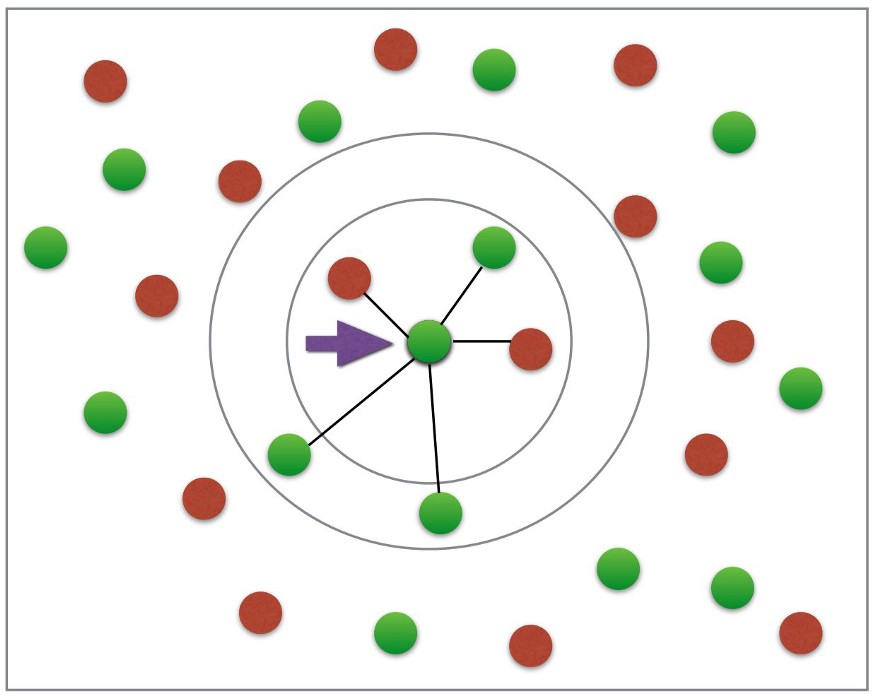

In [776]:
Image(filename='data/images/knn.jpeg',height=300,width=300) 

In [777]:
project_df.head(2)

,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean,desc_author_genre
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,652,2095690,27591,9/16/2006,Scholastic Inc.,war voldemort going well even muggle governmen...,3,fantasy_paranormal_fiction,yes,2006,Harry Potter and the Half-Blood Prince (Harry ...
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,870,2153167,29221,9/1/2004,Scholastic Inc.,door end silent corridor itâ s haunting harry ...,9,fantasy_paranormal_fiction,yes,2004,Harry Potter and the Order of the Phoenix (Har...


In [778]:
project_df_knn=project_df[['title','rating','num_pages','number_of_ratings','text_reviews_count','genre','year_clean']].copy()

Since in the first recommender system we didn't use features like rating, revies, year, etc. This time we will try to use the time to find similar books.

for that first, we need to do some data formatting.

In [779]:
project_df_knn.head(2)

,title,rating,num_pages,number_of_ratings,text_reviews_count,genre,year_clean
0,Harry Potter and the Half-Blood Prince (Harry ...,4.57,652,2095690,27591,fantasy_paranormal_fiction,2006
1,Harry Potter and the Order of the Phoenix (Har...,4.49,870,2153167,29221,fantasy_paranormal_fiction,2004


<AxesSubplot:xlabel='rating'>

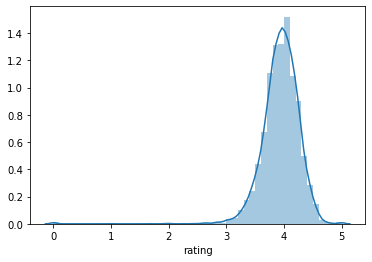

In [780]:
sns.distplot(project_df_knn['rating'])

The data is a bit skewed so we can remove data that has less than 2.5 rating

In [781]:
project_df_knn[project_df_knn['rating']<2.5]['rating'].value_counts()

0.00    16
2.00     4
2.45     1
1.67     1
1.91     1
2.40     1
2.26     1
1.00     1
Name: rating, dtype: int64

We are not loosing too much data so this is dooable 

In [782]:
project_df_knn=project_df_knn[project_df_knn['rating']>2.5]

We can classify the rating into groups to get a better cluster.

In [783]:
project_df_knn.loc[ (project_df_knn['rating'] > 2) & (project_df_knn['rating'] <= 3), 'rating_between'] = "between 2 and 3"
project_df_knn.loc[ (project_df_knn['rating'] > 3) & (project_df_knn['rating'] <= 4), 'rating_between'] = "between 3 and 4"
project_df_knn.loc[ (project_df_knn['rating'] > 4) & (project_df_knn['rating'] <= 5), 'rating_between'] = "between 4 and 5"

In [784]:
project_df_knn.drop('rating',axis=1,inplace=True) # now we can drop the column

Now we can drop the column as we dont need that anymore .

<AxesSubplot:xlabel='num_pages'>

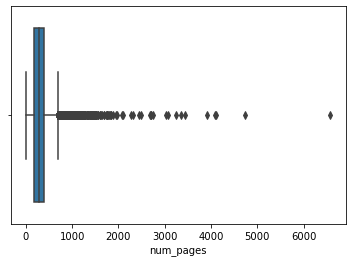

In [785]:
sns.boxplot(project_df_knn['num_pages'])

There are a lot of outliers that can be removed to get a cleaner data

In [786]:
project_df_knn=project_df_knn[project_df_knn['num_pages']<1200]

<AxesSubplot:xlabel='number_of_ratings'>

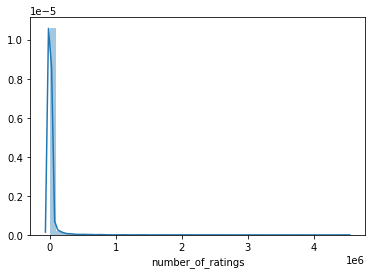

In [787]:
sns.distplot(project_df_knn['number_of_ratings'])

The data is very much skewed so applying log transformation to the data might make it more evenly di

In [788]:
project_df_knn['no_ratingslognorm'] = np.log(project_df_knn['number_of_ratings'])

c:\python38\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [789]:
project_df_knn=project_df_knn[project_df_knn['no_ratingslognorm']>1.8]

In [790]:
project_df_knn=project_df_knn[project_df_knn['no_ratingslognorm']<12.2]

<AxesSubplot:xlabel='no_ratingslognorm'>

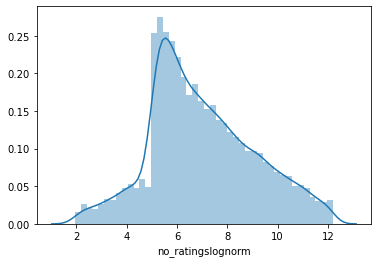

In [791]:
sns.distplot(project_df_knn['no_ratingslognorm'])

It might not be a perfect distribution but its better than we had

In [22]:
def to_int(text):
    return int(text)

In [793]:
project_df_knn=project_df_knn[project_df_knn['text_reviews_count']!='Unavailable']
project_df_knn['text_reviews_count']=project_df_knn['text_reviews_count'].apply(lambda x :to_int(x) )

We are removing entries with no text revies and convert them into integers

In [825]:
project_df_knn.head(2)

,title,num_pages,number_of_ratings,text_reviews_count,genre,year_clean,rating_between,no_ratingslognorm
2,Harry Potter and the Chamber of Secrets (Harry...,352,6333,244,fantasy_paranormal_fiction,2003,between 4 and 5,8.753529
4,"Unauthorized Harry Potter Book Seven News: ""Ha...",152,19,1,not_given,2005,between 3 and 4,2.944439


In [799]:
temp_df=pd.get_dummies(project_df_knn[['genre','rating_between']],drop_first=True)

We can convert the categorical values to one hot enconding for the model

In [800]:
features = pd.concat([ project_df_knn, temp_df], axis=1)
features.drop(['genre','rating_between'],axis=1,inplace=True)
features.head()

,title,num_pages,number_of_ratings,text_reviews_count,year_clean,no_ratingslognorm,genre_Other,genre_children,genre_comics,genre_fantasy_paranormal_fiction,genre_history_biography,genre_mystery_thriller_crime,genre_not_given,genre_poetry_philosophy,genre_romance,genre_young_adult,rating_between_between 3 and 4,rating_between_between 4 and 5
2,Harry Potter and the Chamber of Secrets (Harry...,352,6333,244,2003,8.753529,0,0,0,1,0,0,0,0,0,0,0,1
4,"Unauthorized Harry Potter Book Seven News: ""Ha...",152,19,1,2005,2.944439,0,0,0,0,0,0,1,0,0,0,1,0
6,The Ultimate Hitchhiker's Guide: Five Complete...,815,3628,254,2005,8.196437,0,0,0,1,0,0,0,0,0,0,0,1
8,The Hitchhiker's Guide to the Galaxy (Hitchhik...,215,4930,460,2004,8.503094,0,0,0,1,0,0,0,0,0,0,0,1
9,The Ultimate Hitchhiker's Guide (Hitchhiker's ...,815,2877,195,1996,7.964503,0,0,0,1,0,0,0,0,0,0,0,1


As the features are all in different scale , we have to use min max scaler to keep the scale of the data constant

In [801]:
features.columns

Index(['title', 'num_pages', 'number_of_ratings', 'text_reviews_count',
       'year_clean', 'no_ratingslognorm', 'genre_Other', 'genre_children',
       'genre_comics', 'genre_fantasy_paranormal_fiction',
       'genre_history_biography', 'genre_mystery_thriller_crime',
       'genre_not_given', 'genre_poetry_philosophy', 'genre_romance',
       'genre_young_adult', 'rating_between_between 3 and 4',
       'rating_between_between 4 and 5'],
      dtype='object')

In [802]:
min_max_scaler = MinMaxScaler()
features_no_title = min_max_scaler.fit_transform(features[['num_pages', 'number_of_ratings', 'text_reviews_count',
       'year_clean', 'no_ratingslognorm', 'genre_Other', 'genre_children',
       'genre_comics', 'genre_fantasy_paranormal_fiction',
       'genre_history_biography', 'genre_mystery_thriller_crime',
       'genre_not_given', 'genre_poetry_philosophy', 'genre_romance',
       'genre_young_adult', 'rating_between_between 3 and 4',
       'rating_between_between 4 and 5']])

In [803]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='kd_tree')
model.fit(features_no_title)
dist, idlist = model.kneighbors(features_no_title)

We are using the kd_tree algorithm to find the 5 book , closest to the input book .

In [810]:
def BookRecommender_knn(book_name):
    book_list_name = []
    book_id = features[features['title'] == book_name].index
    print(book_id)
    book_id = book_id[0]
    print(book_name)
    for newid in idlist[book_id]:
        book_list_name.append(project_df.loc[newid].title)
    return book_list_name[1:]

In [823]:
BookRecommender_knn(features['title'][2])


Int64Index([2], dtype='int64')
Harry Potter and the Chamber of Secrets (Harry Potter  #2)


['The Karma Of Brown Folk',
 'Island: Collected Stories',
 'Critique of Pure Reason (Studies in the History of Philosophy)',
 'Storm of the Century',
 'Round Ireland with a Fridge']

In [822]:
BookRecommender_knn(project_df['title'][56])

Int64Index([56], dtype='int64')
The Lord of the Rings: The Art of the Fellowship of the Ring


['The Areas of My Expertise: An Almanac of Complete World Knowledge Compiled with Instructive Annotation and Arranged in Useful Order',
 'Because It Is Bitter  and Because It Is My Heart',
 'Dark Visions',
 'How to Buy  Sell & Profit on eBay: Kick-Start Your Home-Based Business in Just Thirty Days',
 'Eight Black Horses (87th Precinct  #38)']

##### Observation
We can see that the recommender system is not performing that well as the one where we used tf-idf vectorizer on the book description. It is recommending books that are not at all related to the books we are searching for.

### Book to Moive predictor

Recently a lot of books are receiving a movie adaptation. Well recognized movies such as the Harry Potter series, Lord of the rings series, Angels and Demons, The Da Vinci code, and many more are an adaptation of books. This Classifier will try to predict will a book be made to a movie or not.

In [7]:
project_df=pd.read_csv('data/Poject_data.csv',error_bad_lines=False,index_col=0,encoding= 'unicode_escape')

In [8]:
project_df.head(2)

,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,652,2095690,27591,9/16/2006,Scholastic Inc.,The war against Voldemort is not going well; e...,3,fantasy_paranormal_fiction,yes,2006
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,870,2153167,29221,9/1/2004,Scholastic Inc.,There is a door at the end of a silent corrido...,9,fantasy_paranormal_fiction,yes,2004


In [9]:
project_df.shape

(17234, 14)

In [10]:
movie_data=project_df[project_df['Movie']=='yes']

In [11]:
movie_data.shape

(1985, 14)

The data is highly imbalanced as among 17235 entries we have only 1985 was made into movies so to balance the data for the model we will randomly select 2000 entries from the entries which weren't turned into movies. and concatenate them

In [12]:
not_movie_data=project_df[project_df['Movie']=='no'].sample(n=2000,random_state=142)

In [13]:
not_movie_data.head(2)

,book_id,title,author,rating,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean
6335,35539,The Beatles: The Biography,Bob Spitz,4.15,983,9041,417,10/10/2005,Little Brown,"Even before the Beatles hit the big time, a my...",1,Other,no,2005
912,4451,People of the Lie: The Hope for Healing Human ...,M. Scott Peck,3.98,272,6256,459,1/2/1998,Touchstone,In this absorbing and equally inspiring compan...,0,Other,no,1998


In [14]:
classification_df=pd.concat([movie_data, not_movie_data])

In [15]:
classification_df.shape

(3985, 14)

In [16]:
classification_df_1=classification_df.copy()
### we copied the df so that we dont dont chage the original dataframe 

As we have previously used a dataset for classification, We can use the same data formatting we used for the recommendation for knn but tweak it as we are using a different part of the dataset

In [17]:
classification_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3985 entries, 0 to 433
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   book_id             3985 non-null   int64  
 1   title               3985 non-null   object 
 2   author              3985 non-null   object 
 3   rating              3985 non-null   float64
 4   num_pages           3985 non-null   int64  
 5   number_of_ratings   3985 non-null   int64  
 6   text_reviews_count  3985 non-null   object 
 7   year                3985 non-null   object 
 8   publisher           3985 non-null   object 
 9   description         3985 non-null   object 
 10  awards              3985 non-null   object 
 11  genre               3985 non-null   object 
 12  Movie               3985 non-null   object 
 13  year_clean          3985 non-null   int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 467.0+ KB


In [18]:
classification_df_1=classification_df_1[classification_df_1['rating']>2.5]
classification_df_1.loc[ (classification_df_1['rating'] > 2) & (classification_df_1['rating'] <= 3), 'rating_between'] = "between 2 and 3"
classification_df_1.loc[ (classification_df_1['rating'] > 3) & (classification_df_1['rating'] <= 4), 'rating_between'] = "between 3 and 4"
classification_df_1.loc[ (classification_df_1['rating'] > 4) & (classification_df_1['rating'] <= 5), 'rating_between'] = "between 4 and 5"
classification_df_1.drop('rating',axis=1,inplace=True)
classification_df_1=classification_df_1[classification_df_1['num_pages']<1300]


In [19]:
classification_df_1['no_ratingslognorm'] = np.log(classification_df_1['number_of_ratings'])
classification_df_1=classification_df_1[classification_df_1['no_ratingslognorm']>1.8]
classification_df_1=classification_df_1[classification_df_1['no_ratingslognorm']<12.2]

c:\python38\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
classification_df_1=classification_df_1[classification_df_1['text_reviews_count']!='Unavailable']

In [24]:
classification_df_1['text_reviews_count']=classification_df_1['text_reviews_count'].apply(lambda x :to_int(x) )

In [25]:
classification_df_1['text_reviews_count'] = np.log(classification_df_1['text_reviews_count'])
classification_df_1=classification_df_1[classification_df_1['text_reviews_count']!=classification_df_1['text_reviews_count'].min()]

In [26]:
classification_df_1['text_reviews_count']

57       8.423102
75       3.433987
89       5.181784
98       7.576097
123      3.713572
           ...   
9245     2.302585
3385     4.852030
2581     4.875197
12503    3.465736
433      4.867534
Name: text_reviews_count, Length: 3548, dtype: float64

In [27]:
classification_df_1.head(2)

,book_id,title,author,num_pages,number_of_ratings,text_reviews_count,year,publisher,description,awards,genre,Movie,year_clean,rating_between,no_ratingslognorm
57,122,The Power of One (The Power of One #1),Bryce Courtenay,544,69167,8.423102,9/29/1996,Ballantine Books,"In 1939, as Hitler casts his enormous, cruel s...",1,fantasy_paranormal_fiction,yes,1996,between 4 and 5,11.144279
75,164,The Untouchables,Eliot Ness,256,613,3.433987,2/1/1996,Buccaneer Books,The Untouchables is the gripping true story of...,0,history_biography,yes,1996,between 3 and 4,6.418365


In [28]:
classification_df_1['Movie'].value_counts()

no     1938
yes    1610
Name: Movie, dtype: int64

Now we have 1935 entries which has not been made into movies and 1610 entries , which has 

In [29]:
classification_df_1_final=classification_df_1[['num_pages','no_ratingslognorm','text_reviews_count','awards','genre','year_clean','Movie','rating_between']].copy()

In [30]:
classification_df_1_final.head(2)

,num_pages,no_ratingslognorm,text_reviews_count,awards,genre,year_clean,Movie,rating_between
57,544,11.144279,8.423102,1,fantasy_paranormal_fiction,1996,yes,between 4 and 5
75,256,6.418365,3.433987,0,history_biography,1996,yes,between 3 and 4


In [31]:
temp_df=pd.get_dummies(classification_df_1_final[['genre','rating_between']],drop_first=True)

features = pd.concat([ classification_df_1_final, temp_df], axis=1)
label=features['Movie']
features.drop(['genre','rating_between','awards','Movie'],axis=1,inplace=True)

In [32]:
features.head()

,num_pages,no_ratingslognorm,text_reviews_count,year_clean,genre_Other,genre_children,genre_comics,genre_fantasy_paranormal_fiction,genre_history_biography,genre_mystery_thriller_crime,genre_not_given,genre_poetry_philosophy,genre_romance,genre_young_adult,rating_between_between 3 and 4,rating_between_between 4 and 5
57,544,11.144279,8.423102,1996,0,0,0,1,0,0,0,0,0,0,0,1
75,256,6.418365,3.433987,1996,0,0,0,0,1,0,0,0,0,0,1,0
89,191,7.971431,5.181784,2004,0,0,0,0,0,1,0,0,0,0,1,0
98,797,11.029066,7.576097,2003,0,0,0,0,0,0,0,0,0,0,1,0
123,224,6.131226,3.713572,2004,0,0,0,1,0,0,0,0,0,0,1,0


In [33]:
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

In [34]:
le = preprocessing.LabelEncoder()
labels=le.fit_transform(label)

In [35]:
model_arr=[]
accuracy_arr=[]
std_arr=[]

In [36]:
def clf_result(classifier,classifier_name):
    acc_scores = cross_val_score(classifier, features, labels, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=142),n_jobs=-1)
    accuracy=acc_scores.mean()
    std=acc_scores.std()
    print("Classifier_name :",classifier_name)
    print("accuracy: ",accuracy)
    print("standard dev: ",std)
    model_arr.append(classifier_name)
    accuracy_arr.append(accuracy)
    std_arr.append(std)
    return acc_scores
    
    

This function takes The classifier and Classifier name as arcuments , where classifier is the model we are traiing and testing the model on . the fuction uses 10 fold cross validation to calculate the accuracy , recall ,percission, and f1 score od the model. as we have a relatively small dataset , so cross validation is better that using train and test split . 

In [37]:
lgr = LogisticRegression(random_state=142)
lgr_acc=clf_result(lgr,"LogisticRegression")

Classifier_name : LogisticRegression
accuracy:  0.8159576669053872
standard dev:  0.02279013209686464


In [38]:
knn = KNeighborsClassifier(n_neighbors=3)
knn_acc=clf_result(knn,"KNeighborsClassifier")

Classifier_name : KNeighborsClassifier
accuracy:  0.7838378292352988
standard dev:  0.03230395891747344


In [39]:
mlp = MLPClassifier(alpha=1, max_iter=1000,random_state=142,hidden_layer_sizes=(100,100))
mlp_acc=clf_result(mlp," MLPClassifier")

Classifier_name :  MLPClassifier
accuracy:  0.8162425399856769
standard dev:  0.02333306857081861


## Observation
As we can see that even with simple features and Algorighm we get accuracy around 80 % and highest  accuracy is of  Multilayerd perceptron annd the lowest being KNN.So now we will add publisher and author to see if the accuracy increases.

In [40]:
classification_df_2=classification_df_1.copy() 

In [41]:
classification_df_2['author']=le.fit_transform(classification_df_2['author'])
classification_df_2['publisher']=le.fit_transform(classification_df_2['publisher'])

In [42]:
classification_df_2_final=classification_df_2[['num_pages','no_ratingslognorm','text_reviews_count','awards','genre','year_clean','Movie','rating_between','author','publisher']]

In [43]:
temp_df=pd.get_dummies(classification_df_2_final[['genre','rating_between']],drop_first=True)

features = pd.concat([ classification_df_2_final, temp_df], axis=1)
label=features['Movie']
features.drop(['genre','rating_between','awards','Movie'],axis=1,inplace=True)

In [44]:
labels=le.fit_transform(label)

In [45]:
features

,num_pages,no_ratingslognorm,text_reviews_count,year_clean,author,publisher,genre_Other,genre_children,genre_comics,genre_fantasy_paranormal_fiction,genre_history_biography,genre_mystery_thriller_crime,genre_not_given,genre_poetry_philosophy,genre_romance,genre_young_adult,rating_between_between 3 and 4,rating_between_between 4 and 5
57,544,11.144279,8.423102,1996,229,601,0,0,0,1,0,0,0,0,0,0,0,1
75,256,6.418365,3.433987,1996,536,667,0,0,0,0,1,0,0,0,0,0,1,0
89,191,7.971431,5.181784,2004,298,1365,0,0,0,0,0,1,0,0,0,0,1,0
98,797,11.029066,7.576097,2003,770,1092,0,0,0,0,0,0,0,0,0,0,1,0
123,224,6.131226,3.713572,2004,474,1205,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9245,16,5.147494,2.302585,2004,1887,876,0,1,0,0,0,0,0,0,0,0,1,0
3385,576,8.627302,4.852030,2006,450,598,0,0,0,1,0,0,0,0,0,0,0,1
2581,232,8.575273,4.875197,2008,1192,723,0,0,1,0,0,0,0,0,0,0,0,1
12503,231,5.342334,3.465736,2012,824,1204,0,0,0,1,0,0,0,0,0,0,0,1


In [46]:
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

In [47]:
lgr = LogisticRegression(random_state=142)
lgr2_acc=clf_result(lgr,"LogisticRegression_2")

Classifier_name : LogisticRegression_2
accuracy:  0.8734518978276439
standard dev:  0.010993379383880567


In [48]:
knn = KNeighborsClassifier(n_neighbors=3)
knn2_acc=clf_result(knn,"KNeighborsClassifier_2")

Classifier_name : KNeighborsClassifier_2
accuracy:  0.8821970239516194
standard dev:  0.019952839911540943


In [49]:
mlp = MLPClassifier(alpha=1, max_iter=1000,random_state=142,hidden_layer_sizes=(100,100))
mlp2_acc=clf_result(mlp," MLPClassifier_2")

Classifier_name :  MLPClassifier_2
accuracy:  0.9123545794541259
standard dev:  0.014061525362664168


## Observation
We can see that adding more data has increased all of our model's accuracy significantly. but as before the highest accuracy is of Multilayered perceptron followed by Logistic regression and the lowest being KNN.

In [50]:
eval_df=pd.DataFrame()
eval_df['model']=model_arr
eval_df['accuracy']=accuracy_arr
eval_df['standard_dev']=std_arr

In [51]:
eval_lgr=eval_df.loc[[0,3]]
eval_knn=eval_df.loc[[1,4]]
eval_mlp=eval_df.loc[[2,5]]


In [52]:
eval_df

,model,accuracy,standard_dev
0,LogisticRegression,0.815958,0.022790
1,KNeighborsClassifier,0.783838,0.032304
2,MLPClassifier,0.816243,0.023333
3,LogisticRegression_2,0.873452,0.010993
4,KNeighborsClassifier_2,0.882197,0.019953
5,MLPClassifier_2,0.912355,0.014062


In [53]:
eval_df_final=pd.concat([eval_lgr, eval_knn,eval_mlp])

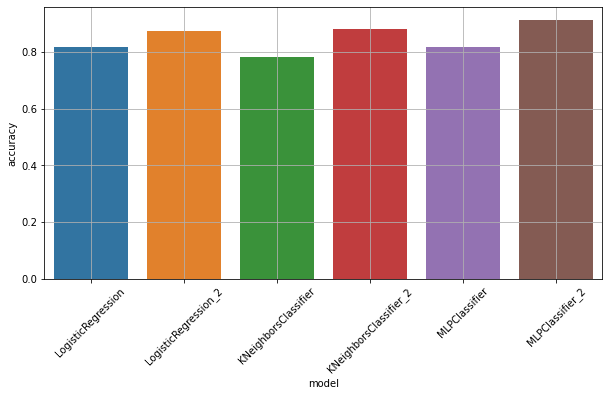

In [54]:
plt.figure(figsize=(10,5))
chart =sns.barplot(data=eval_df_final,x="model", y="accuracy")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.grid()

### Observation
It can be seen that we have received a relatively high accuracy from all of the algorithms but overall models with added features performed better and in both cases, Multi-layered perceptron performed better than other algorithms.
To get a more absolute result we will perform a t-test to verify the hypothesis

In [55]:
from scipy.stats import ttest_ind

###### For classifiers without addiditonal features

In [60]:
s,p=ttest_ind(lgr_acc,mlp_acc)
print("p:",p)


p: 0.979384352840892


In [61]:
s,p=ttest_ind(knn_acc,mlp_acc)
print("p:",p)

p: 0.025283823575642888


In [62]:
s,p=ttest_ind(lgr_acc,knn_acc)
print("p:",p)

p: 0.025396282218741247


From the T tests above we can see that there are no significant difference between the models . as all the p values are more tham 0.05

##### For classifiers with addiditonal features

In [56]:
s,p=ttest_ind(lgr2_acc,mlp2_acc)
print("p:",p)


p: 3.811302587625453e-06


In [57]:
s,p=ttest_ind(knn2_acc,mlp2_acc)
print("p:",p)

p: 0.0016154846944114575


In [59]:
s,p=ttest_ind(lgr2_acc,knn2_acc)
print("p:",p)

p: 0.26453740742271037


From the following T-tests, we can see That after adding more features MLP classifier is definitely better than the other algorithms but there is no significant difference between Logistic regression and Knn.
So we are going to work with the MLP classifier and try to improve the accuracy even more. by some hyperparameter tuning.

#### Choose number of hidden layers

In [63]:
# Try different solvers
cv_scores = []
cv_scores_std = []
hidden_layer_sizes=[(100),(100,100),(100,100,100),(100,100,100,100)]
for i in hidden_layer_sizes:
    clf_mlp = MLPClassifier(alpha=1, max_iter=1000,random_state=142,hidden_layer_sizes=i)
    scores = cross_val_score(clf_mlp, features, labels, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=142),n_jobs=-1)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

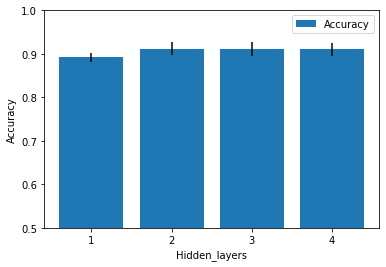

In [65]:
plt.bar(["1","2","3","4"], cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Hidden_layers')
plt.ylim([0.5, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [66]:
cv_scores

[0.8920609532903636, 0.9123545794541259, 0.9115118962361741, 0.910666825813639]

It can be seen that adding extra layers after the secong layer doesnt have any significant difference in the accuracy so we can keep the number of layer to 2 .

#### Choose solver for the learning process

In [67]:
# Try different solvers
cv_scores = []
cv_scores_std = []
solvers = ['lbfgs', 'sgd', 'adam']
for i in solvers:
    clf_mlp = MLPClassifier(alpha=1, max_iter=1000,solver=i,random_state=142,hidden_layer_sizes=(100,100))
    scores = cross_val_score(clf_mlp, features, labels, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=142),n_jobs=-1)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

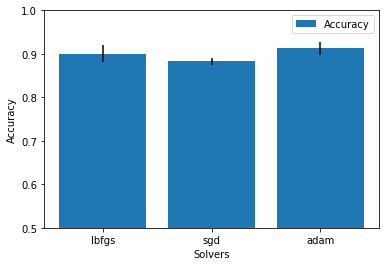

In [68]:
# Plot the relationship
plt.bar(solvers, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Solvers')
plt.ylim([0.5, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [69]:
cv_scores

[0.9005220020689106, 0.8830365242301266, 0.9123545794541259]

In [70]:
cv_scores_std

[0.019422768879285204, 0.008337208329824078, 0.014061525362664168]

Adam seems to provide us with the best results when it comes to the accuracy but when it comes to consistency , SGD has the least standard deviation . We will keep the default optimizer for out model , which is adam . 

#### Activation functions

In [71]:
cv_scores = []
cv_scores_std = []
activation = ['identity', 'logistic','tanh','relu']
for i in activation:
    clf_mlp = MLPClassifier(alpha=1, max_iter=1000,activation=i,solver='adam',random_state=142,hidden_layer_sizes=(100,100))
    scores = cross_val_score(clf_mlp, features, labels, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=142),n_jobs=-1)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

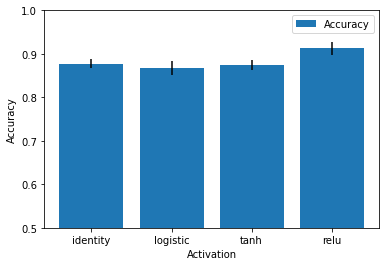

In [72]:
plt.bar(activation, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Activation')
plt.ylim([0.5, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


relu seems to provide us with the best results when it comes to the accuracy.

#### Use different values of alpha

In [74]:

# Try different regulaization parameters
cv_scores = []
cv_scores_std = []
alphas = [0.0001,0.001,0.01, 0.1,1]
for i in alphas:
    clf_mlp = MLPClassifier(alpha=i, max_iter=1000,activation='relu',solver='adam',random_state=142,hidden_layer_sizes=(100,100))
    scores = cross_val_score(clf_mlp, features, labels, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=142),n_jobs=-1)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

In [77]:
cv_scores

[0.9126346781252487,
 0.9126346781252487,
 0.9131980584069389,
 0.9123569666587095,
 0.9123545794541259]

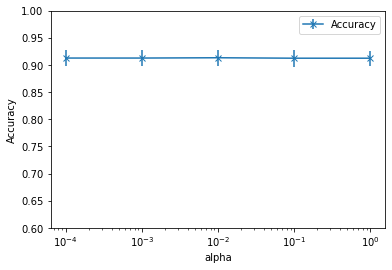

In [78]:
# Plot the relationship
plt.errorbar(alphas, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylim([0.6, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Even though there is very small difference in results ,from the folowing leatning rates , 0.01 seems to give us the best result . 

## Conclusion

#### Receomender System :
From the above analysis, we can say that the book description is the most important factor when choosing similar books.
and adding other features to them by concatenating before using TF-IDF vectorizer, gives a much better result than description alone.
using other features like rating and review count in KNN doesn't seem to be a good option as they don't hold the information regarding the context.

###### Problem :
There were some problems with the dataset, as it wasn't fully cleaned. there were some repeated books, as the same book can be of different editions.
* Using a better and cleaner dataset will give us a better result when it comes to finding similar books 
* Using a Deep Neural network like LSTm or using Word2vec might also improve the results


#### Book to movies prediction :
We have used several different models to predict if a book will be a movie representation or not.
the models we have used are Logistic Regression, K Nearest Neighbour, and Multi-Layered perceptron.

We have seen adding features like author and publisher increases the prediction significantly, so it can be said that the author and publisher are important when it comes to deciding which books will have movie representations. as we have a low dataset we had to use 10 fold cross-validation. 

###### Problem :

* There was a lack of data for books that were turned to movies, increasing the number of samples will increase the accuracy.